# BC 205 - Villa Colombia

In [1]:
%load_ext autoreload
%autoreload 2

from Ubidots_library_acruz import Ubidots

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from datetime import datetime

import os
from dotenv import dotenv_values
config = dotenv_values(".env")

import requests
import json

from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns


from sys import exit

import os


## Functions

In [2]:
def calculate_interval_duration_days(interval):
    dt_start = pd.to_datetime(interval['start'])
    dt_end = pd.to_datetime(interval['end'])
    return (dt_end - dt_start).days


def count_days(df):
    return len(np.unique(df.index.date))


def find_date_overlap(baseline, study):
    latest_start = max(
        pd.to_datetime(baseline['start']),
        pd.to_datetime(study['start'])
    )
    earliest_end = min(
        pd.to_datetime(baseline['end']),
        pd.to_datetime(study['end'])
    )
    delta = (earliest_end - latest_start).days + 1
    return int(max(0, delta))


def check_intervals(baseline, study, max_overlap=0):
    overlap = find_date_overlap(baseline, study)
    if (overlap > max_overlap):
        print(
            "Error: The baseline and study intervals must not overlap. "
            f"Current overlap is {overlap} days"
        )
        exit()


def make_request(LST_DEVICE_ID_TO_REQUEST, LST_VAR_LABELS, LST_VAR_FIELDS, date_interval, DATE_FORMAT, _TOKEN):
    # LST_DEVICE_ID_TO_REQUEST must be a list of devices, even if it contains only one item
    if not isinstance(LST_DEVICE_ID_TO_REQUEST, list):
        LST_DEVICE_ID_TO_REQUEST = [LST_DEVICE_ID_TO_REQUEST]

    # For bulk raw data requests the Ubidots API requires
    # a list of variable IDs, not device IDs.
    # Starting from variable labels requires fetching all 
    # variable info, then filtering IDs based on labels.
    DCT_AVAILABLE_VAR_ID = Ubidots.get_var_id_for_multiple_devices(LST_DEVICE_ID_TO_REQUEST, LST_VAR_LABELS, _TOKEN)

    # the request must be made in millisecond timestamps
    start_timestamp = str_date_to_int_timestamp_ms(date_interval['start'], DATE_FORMAT)
    end_timestamp = str_date_to_int_timestamp_ms(date_interval['end'], DATE_FORMAT)

    # The request is made with an array of all variable IDs.
    response = Ubidots.get_raw_data(
        list(DCT_AVAILABLE_VAR_ID.keys()), 
        LST_VAR_FIELDS, 
        start_timestamp, 
        end_timestamp, 
        _TOKEN, 
        join=False
    )

    # The connection is left open by default
    response.close()
    return response

def str_date_to_int_timestamp_ms(date_string, date_format):
    element = datetime.strptime(date_string, date_format)
    return int(datetime.timestamp(element)) * 1000

def flatten_bulk_raw_response(r_json_data, headers):
    lst_df_idx = []
    for idx in range(len(r_json_data)):
        df_idx = pd.DataFrame(r_json_data[idx], columns=headers)
        lst_df_idx.append(df_idx)

    return pd.concat(lst_df_idx).reset_index(drop=True)

def convert_timezone(obj, from_tz='utc', to_tz='America/Bogota'):
    if isinstance(obj, str):
        obj = pd.to_datetime(obj).tz_localize(from_tz).tz_convert(to_tz)
    elif isinstance(obj, datetime):
        obj.tz_localize(from_tz).tz_convert(to_tz)
    elif isinstance(obj, pd.DataFrame):
        # A DatetimeIndex must be set to allow for easy 
        # timezone conversion
        obj.set_index('datetime', inplace=True)
        obj = obj.tz_localize(from_tz).tz_convert(to_tz)

    return obj

def parse_flat_data(df, DCT_AVAILABLE_VAR_ID):
    # The Ubidots API does not return a variable-label field
    # and naming is inconsistent, so labels must be mapped from ids.
    df['variable'] = df['variable'].map(DCT_AVAILABLE_VAR_ID)

    # datetimes are human readable
    df["datetime"] = pd.to_datetime(df["timestamp"], unit='ms')
    df = convert_timezone(df)
    
    df.drop_duplicates(subset=['timestamp', 'variable', 'device'], inplace=True)
    return df.drop(columns='timestamp')

def get_available_devices(device_group_label):
    # The API requires a tilde leading the device group label
    # but the user shouldn't be expected to know this
    tilde_device_group_label = '~' + device_group_label
    r_devices = Ubidots.get_device_group_devices(_TOKEN, tilde_device_group_label)
    dct_available_devices = dict(zip(r_devices['id'], r_devices['label']))
    return dct_available_devices

def get_available_variables(device_id):
    if isinstance(device_id, list):
        dct_variables = Ubidots.get_var_id_for_multiple_devices(device_id, LST_VAR_LABELS, _TOKEN)
    else:
        variables = Ubidots.get_all_variables_from_device(_TOKEN, device_id)
        dct_variables = dict(zip(variables['variable_id'], variables['variable_label']))
    return dct_variables

def show_available_devices(dct_available_devices):
    print("Available devices in group:")
    print(json.dumps(dct_available_devices, sort_keys=True, indent=4))
    return dct_available_devices

def show_available_variables(dct_variables):
    print("Available variables:")
    print(json.dumps(dct_variables, sort_keys=True, indent=4))
    return dct_variables

def show_response_contents(df):
    print("The response contains:")
    print(json.dumps(list(df['variable'].unique()), sort_keys=True, indent=4))
    print(json.dumps(list(df['device'].unique()), sort_keys=True, indent=4))

def show_variable_labels_to_request():
    print("Variable labels to request: ")
    print(json.dumps(LST_VAR_LABELS, sort_keys=True, indent=4))

def show_outlier_counts(df):
    is_selection = (
        (df['outlier']==True)
    )
    print("Outlier counts:")
    print(df.loc[is_selection, 'variable'].value_counts())

def double_subset_rolling_clean(df, subset_1=None, subset_2=None, clean_on=None):
    lst_df = []
    for ss_label_1 in df[subset_1].unique():
        for ss_label_2 in df[subset_2].unique():
            is_selection = (
                (df[subset_1]==ss_label_1)
                & (df[subset_2]==ss_label_2)
            )
            df_temp = df[is_selection].copy()
            series = df_temp[clean_on]

            # long window high percentile
            is_long_outlier = rolling_percentile_outlier(
                series, 
                LONG_WINDOW, 
                LONG_CONFIDENCE_INTERVAL
            )

            # TODO: find a way to filter out long outliers
            # before feeding into short outlier method

            # short window low percentile
            is_short_outlier = rolling_percentile_outlier(
                series, 
                SHORT_WINDOW, 
                SHORT_CONFIDENCE_INTERVAL
            )

            if (SMOOTHING_METHOD == 'median'):
                df_temp[clean_on] = series.rolling(window=SMOOTHING_WINDOW, center=True).median()
            elif (SMOOTHING_METHOD == 'mean'):
                df_temp[clean_on] = series.rolling(window=SMOOTHING_WINDOW, center=True).mean()

            df_temp['outlier'] = ((is_long_outlier) | (is_short_outlier))
            lst_df.append(df_temp)

    return pd.concat(lst_df)

def rolling_percentile_outlier(series, window, confidence_interval):
    upper_quantile = (1 + confidence_interval/100)/2
    lower_quantile = 1 - upper_quantile
    
    s_upper_percentile = series.rolling(window=window, center=True).quantile(
        quantile=upper_quantile, 
        axis=0,
        numeric_only=True, 
        interpolation='linear'
    )

    s_lower_percentile = series.rolling(window=window, center=True).quantile(
        quantile=lower_quantile, 
        axis=0,
        numeric_only=True, 
        interpolation='linear'
    )

    is_outlier = (
        (series > s_upper_percentile)
        | (series < s_lower_percentile)
    )

    return is_outlier

def discard_date_intervals(df):
    for interval in DATE_INTERVALS_TO_DISCARD:
        is_outside_range = (
            (df.index < interval[0])
            | (df.index > interval[1])
        )
    return df[is_outside_range].copy()

def run_cleaning_analysis(variable=None, start_date=None, end_date=None, bins=None, wide_figsize=(30,10), square_figsize=(10,10)):
    device_name = df['device_name'][0]

    is_sel_1 = (
        (df['variable']==variable)
        & (df.index>start_date)
        & (df.index<end_date)
    )

    is_sel_2 = (
        (df['outlier']==False)
        & (df['variable']==variable)
        & (df.index>start_date)
        & (df.index<end_date)
    )

    s_1 = df.loc[is_sel_1, 'value']
    s_2 = df.loc[is_sel_2, 'value']

    s_res = s_1 - s_2
    lst_series = [
        s_1, 
        s_2
    ]

    plot_list_series(lst_series, device_name, wide_figsize, draw_markers=False)
    plot_list_series([s_res], device_name, wide_figsize, draw_markers=False)

    plt.figure(figsize=square_figsize)
    plt.scatter(s_res.index, s_res)
    plt.show()

    s_res.hist(bins=bins, figsize=square_figsize)

def request_data():
    # A user might select baseline and study intervals
    # which are sufficiently far apart that fetching
    # the data in between is very inefficient.
    # So it's best to make a request per interval.
    response_bl = make_request(
        LST_DEVICE_ID_TO_REQUEST, 
        LST_VAR_LABELS, 
        LST_VAR_FIELDS, 
        BASELINE_DATE_INTERVAL, 
        DATE_FORMAT, 
        _TOKEN
    )

    response_st = make_request(
        LST_DEVICE_ID_TO_REQUEST, 
        LST_VAR_LABELS, 
        LST_VAR_FIELDS, 
        STUDY_DATE_INTERVAL, 
        DATE_FORMAT, 
        _TOKEN
    )
    return response_bl, response_st


def parse_response(response_bl, response_st):
    # The response is a JSON and it must be flattened into a table
    df_bl = flatten_bulk_raw_response(response_bl.json()['results'], LST_HEADERS)

    # Some parsing is required, including pivoting by variable
    df_bl = parse_flat_data(df_bl, DCT_AVAILABLE_VARIABLES)

    # The response is a JSON and it must be flattened into a table
    df_st = flatten_bulk_raw_response(response_st.json()['results'], LST_HEADERS)

    # Some parsing is required, including pivoting by variable
    df_st = parse_flat_data(df_st, DCT_AVAILABLE_VARIABLES)

    print(f"Shape of baseline data: {df_bl.shape}")
    print(f"Shape of study data: {df_st.shape}")

    return pd.concat([df_bl, df_st])

def apply_datetime_transformations(df):
    df['dow'] = pd.to_datetime(df.index).dayofweek
    df['dow'] = df['dow'].map(dct_dow)
    
    df['hour'] = pd.to_datetime(df.index).hour
    df['year'] = pd.to_datetime(df.index).year
    df['month'] = pd.to_datetime(df.index).month
    df['day'] = pd.to_datetime(df.index).day

    df.sort_values(by=['datetime', 'variable'], inplace=True)
    return df

def post_process_data(df):
    # Discard first entry before cleaning as it might not belong to interval
    # sort by datetime to guarantee chronological order when dropping rows
    df.sort_values(by=['datetime', 'variable'], inplace=True)
    # TODO: convert to double subset on devices and variables.
    # n-vars must be dropped per variable per device
    df = subset_drop_first_n_rows(df, subset='variable', n_rows=1)

    # TODO: organize this cell better. Maybe wrap in functions.
    if len(DATE_INTERVALS_TO_DISCARD)>0:
        df = discard_date_intervals(df, DATE_INTERVALS_TO_DISCARD)

    if (clean_data is True):
        df = double_subset_rolling_clean(
            df, 
            subset_1='device', 
            subset_2='variable', 
            clean_on='value'
        )

    # plotting requires day of week and hour of day labels


    apply_datetime_transformations(df)


    return df

def split_into_baseline_and_study(df, baseline_interval, study_interval):
    # Slicing on non-monotonic indexes is deprecated so sorting is a must
    df.sort_index(inplace=True)
    df_baseline = df[baseline_interval['start']:baseline_interval['end']]
    df_study = df[study_interval['start']:study_interval['end']]
    return df_baseline, df_study

def discard_date_intervals(df, discard_date_interval):
    for interval in discard_date_interval:
        is_outside_range = (
            (df.index < interval[0])
            | (df.index > interval[1])
        )
    return df[is_outside_range].copy()

def plot_list_series(lst_series, device_name, figsize, draw_markers=True):
    plt.figure(figsize=figsize)
    for series in lst_series:
        plt.plot(series, linestyle='-', alpha=0.8)

        if (draw_markers is True):
            plt.scatter(series.index, series, s=2, alpha=1, color='k')
        
    plt.title(f"{device_name}")
    plt.ylim(bottom=-1)
    plt.axhline(y=0, color='k')
    plt.show()

def subset_plot_long_df(df, device_label, wide_figure_size, values=None, subset=None, draw_markers=False):
    lst_series = []
    for subset_var in df[subset].unique():
        series = df.loc[(df[subset]==subset_var), values]
        lst_series.append(series.rename(subset_var))

    # print(lst_series)

    plot_list_series(
        lst_series, 
        device_label, 
        wide_figure_size, 
        draw_markers=draw_markers
    )

def plot_df(df, device_label, wide_figure_size, draw_markers=False):
    lst_series = [df[s] for s in df.columns]
    plot_list_series(lst_series, device_label, wide_figure_size, draw_markers=draw_markers)

def plot_confidence_intervals(df_bl, df_s, confidence_interval, title, figsize, x=None, y=None, hue=None, hue_order=None, individual=False, label_style=False):
    label_bl = None
    label_st = None

    if (label_style is True):
        label_bl = 'Línea base'
        label_st = 'Periodo de estudio'
    
    if (individual is True):
        plt.figure()

    sns.lineplot(
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        data=df_bl.reset_index(), 
        ci=confidence_interval,
        estimator=np.mean,
        # palette="flare",
        label=label_bl
    )

    sns.lineplot(
        x=x,
        y=y,
        hue=hue,
        hue_order=hue_order,
        linestyle="dashed",
        data=df_s.reset_index(), 
        ci=None,
        legend=False,
        estimator=np.mean,
        # palette="flare",
        label=label_st
    )
    plt.title(title + f" - Intervalo de confianza: {confidence_interval}%")
    plt.xlabel('Hora del día')
    plt.ylabel('Consumo horario [kWh]')
    plt.legend()
    if (individual is True):
        plt.show()
    # plt.savefig('fig3/'+str(title)+'.png', dpi=300)

    # plt.savefig(f'figuras/{title}.png', dpi=300)
    # sns.set(rc={'figure.figsize':figsize})

def run_pareto_analysis(df):
    # ea-total must be dropped from pareto
    is_target_var = (
        (df['variable']!=ACTIVE_ENERGY_LABEL)
        & (df['variable'].isin(Energy_VAR_LABELS))
    )
    df_pareto = df[is_target_var].copy()

    s_pareto = df_pareto['value'].groupby(df_pareto['variable']).sum()
    s_pareto.sort_values(ascending=False, inplace=True)

    # Identify main variables
    s_delta = s_pareto / s_pareto.sum()*100
    elbow = s_delta.diff().astype(float).idxmin()
    idx = s_delta.index.get_loc(elbow)
    lst_main_labels = list(s_delta.iloc[:idx+1].index)

    # make hue order before changing names
    hue_order = make_hue_order(s_delta, lst_main_labels, new_label='ea-otros')

    # The analysis is needed for power variables

    return s_pareto


def plot_pareto(series):
    s_2 = series.cumsum() / series.sum()*100

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.bar(series.index, series, color="C0")

    ax2.plot(series.index, s_2, color="C1", marker="D", ms=7)
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.set_ylim(ymin=0)

    ax1.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")
    plt.show()

def make_hue_order(s_delta, lst_main_labels, new_label=None):
    is_main_var = s_delta.index.isin(lst_main_labels)
    s_sorter = s_delta[is_main_var]
    s_sorter[new_label] = s_delta[~is_main_var].sum()
    s_sorter.sort_values(ascending=False, inplace=True)
    return list(s_sorter.index)

def assemble_aggregator(lst_non_value_cols, value_method, bulk_method):
    # make sure keys start with 'value'
    lst_non_value_cols.remove('value')

    lst_keys = ['value']
    lst_keys.extend(lst_non_value_cols)

    # assign value_method to value, bulk_method to rest
    lst_values = [value_method]
    lst_values.extend([bulk_method]*len(lst_non_value_cols))

    return dict(zip(lst_keys, lst_values))


def subset_group_by(df, agg_func=None, subset=None, group_by=None):
    lst_df = []
    for label in df[subset].unique():
        is_selection = (df[subset]==label)
        df_temp = df[is_selection].groupby(group_by).agg(agg_func)
        df_temp.drop(columns=group_by, inplace=True)
        lst_df.append(df_temp)

    return pd.concat(lst_df, ignore_index=False)


def subset_resample(df, agg_func=None, subset=None, freq=None):
    lst_df = []
    for label in df[subset].unique():
        is_selection = (df[subset]==label)
        df_temp = df[is_selection].resample(freq).agg(agg_func)
        lst_df.append(df_temp)

    return pd.concat(lst_df, ignore_index=False).dropna(how='all')


def subset_drop_first_n_rows(df, subset=None, n_rows=None):
    lst_df = []
    for label in df[subset].unique():
        is_selection = (df[subset]==label)
        df_temp = df[is_selection]
        lst_df.append(df_temp.iloc[n_rows:, :])

    return pd.concat(lst_df, ignore_index=False)

def lump_secondary_variables(df, lst_main_labels, new_variable_label, dct_agg, by=None):
    """"
    To avoid using the term "grouped" which might imply a groupby operation.
    Lumped variables are termed "others" and represent a smaller quatity than main variables.
    """
    # TODO: use by= to loop through devices
    # replace secondary variable labels
    is_main_var = df['variable'].isin(lst_main_labels)
    df.loc[~is_main_var, 'variable'] = new_variable_label

    lst_df = []
    for variable in df['variable'].unique():
        df_sel = df[df['variable']==variable]
        
        # index must be unique per variable
        df_output = df_sel.groupby(df_sel.index).agg(dct_agg)
        lst_df.append(df_output)

    return pd.concat(lst_df, ignore_index=False)

def find_consumption_delta_per_variable(df_bl, df_st, merge_on=None):
    """
    Negative means a decrease in energy consumption
    """
    df = pd.merge(df_bl, df_st, on=merge_on)
    df['delta'] = df['value_y'] - df['value_x']
    return df[['delta', 'variable']]

def subplots_stack(df1, df2, figsize):
    df1_wide = df1.pivot(index=None, columns='variable', values='value')
    df2_wide = df2.pivot(index=None, columns='variable', values='value')

    f, (ax, bx) = plt.subplots(1,2,sharey=True) # like mine
    ax.stackplot(df1_wide.index, df1_wide.T, labels=list(df1_wide.columns))
    bx.stackplot(df2_wide.index, df2_wide.T, labels=list(df2_wide.columns))
    plt.legend()
    plt.show()

## Configuration

In [3]:
# Cleaning parameters
clean_data = True
validate_cleaning = False

SHORT_WINDOW = 4 #'5h'
SHORT_CONFIDENCE_INTERVAL = 97.5

LONG_WINDOW = 480 # '5D'
LONG_CONFIDENCE_INTERVAL = 99

SMOOTHING_METHOD = 'mean'
SMOOTHING_WINDOW = 4 # '180min'

# Plotting parameters
confidence_interval = 95

# Ubidots API
API_URL = 'https://industrial.api.ubidots.com/api/v1.6/devices/'
_TOKEN: str = config["token"]
LST_VAR_FIELDS = ["value.value", "variable.id", "device.label", "device.name", "timestamp"]
LST_HEADERS = ['value', 'variable', 'device', 'device_name', 'timestamp']

# Date and Time
DATETIME_FORMAT = "%Y-%m-%dT%H:%M:%S"
DATE_FORMAT = "%Y-%m-%d"
LOCAL_TIMEZONE = 'America/Bogota'


wide_figure_size = (21,7)

# General parameters
ALLOWED_DATE_OVERLAP = 0
DAYS_PER_MONTH = 365.25/12

# Ubidots data parameters
agg_frequency = '1H'

dct_dow = {
    0:'lunes',
    1:'martes',
    2:'miércoles',
    3:'jueves',
    4:'viernes',
    5:'sábado',
    6:'domingo',
} 

plt.figure()
plt.show()
sns.set(rc={'figure.figsize': wide_figure_size})
plt.close()

save_figures = False
show_optional_figures = False
cop_per_kwh = 692.29

# Specify the date interval to fetch data from
# the format must be: 'YYYY-MM-DD'
BASELINE_DATE_INTERVAL = {
    'start': '2022-01-01',
    'end': '2022-05-30'
}

STUDY_DATE_INTERVAL = {
    'start': '2022-06-01',
    'end': '2022-07-01'
}

check_intervals(BASELINE_DATE_INTERVAL, STUDY_DATE_INTERVAL, ALLOWED_DATE_OVERLAP)


DATE_INTERVALS_TO_DISCARD = [
#   ['2022-05-11', '2022-05-22']
]

NOCTURNE = [0, 1, 2, 3, 4, 5, 19, 20, 21, 22, 23]

device_group_label = 'bancolombia'
dct_available_devices = get_available_devices(device_group_label)
# LST_DEVICE_ID_TO_REQUEST = list(dct_available_devices.keys())
LST_DEVICE_ID_TO_REQUEST = '622a72e8fbcb750090b9135e'

ACTIVE_ENERGY_LABEL = 'consumo-activa-total'
ACTIVE_POWER_LABEL = 'pa-total'
POWER_NON_MAIN_LABEL = 'pa-otros' # not used for Molinos


# LST_VAR_LABELS = [ACTIVE_POWER_LABEL]
Energy_VAR_LABELS = ('aa-consumo-activa', 'ilu-consumo-activa')
Power_VAR_LABELS = ('aa-potencia-activa', 'ilu-potencia-activa')

SUB_STR = ('aa', 'front', 'ilu', 'consumo-activa', 'consumo-energia-reactiva')
DCT_AVAILABLE_VARIABLES = get_available_variables(LST_DEVICE_ID_TO_REQUEST)
LST_VAR_LABELS = [s for s in DCT_AVAILABLE_VARIABLES.values() if s.startswith(SUB_STR)]
LST_VAR_LABELS.sort()
show_variable_labels_to_request()

PICKLED_DATA_FILENAME = 'parsed_response_Villa_Colombia.pkl'

<Figure size 432x288 with 0 Axes>

Variable labels to request: 
[
    "aa-consumo-activa",
    "aa-potencia-activa",
    "consumo-energia-reactiva-total",
    "front-consumo-activa",
    "front-potencia-activa",
    "front-tension-1",
    "front-tension-2",
    "front-tension-3",
    "ilu-consumo-activa",
    "ilu-potencia-activa"
]


## Data loading

In [4]:
df = None
use_pickled_data = False

if (use_pickled_data is True):
    df = pd.read_pickle(PICKLED_DATA_FILENAME)
else:

    response_bl, response_st = request_data()
    df = parse_response(response_bl, response_st)
    pd.to_pickle(df, PICKLED_DATA_FILENAME)


show_response_contents(df)

Shape of baseline data: (0, 4)
Shape of study data: (5980, 4)
The response contains:
[
    "aa-consumo-activa",
    "aa-potencia-activa",
    "consumo-energia-reactiva-total",
    "front-consumo-activa",
    "front-potencia-activa",
    "front-tension-1",
    "front-tension-2",
    "front-tension-3",
    "ilu-consumo-activa",
    "ilu-potencia-activa"
]
[
    "bc54"
]


## Preprocessing

In [5]:
# df = post_process_data(df)
print(df["variable"].unique())


['aa-consumo-activa' 'aa-potencia-activa' 'consumo-energia-reactiva-total'
 'front-consumo-activa' 'front-potencia-activa' 'front-tension-1'
 'front-tension-2' 'front-tension-3' 'ilu-consumo-activa'
 'ilu-potencia-activa']


In [6]:
# df_bl = df.loc['2022-05-01':'2022-05-31']
df_st = df.loc['2022-06-01':'2022-06-30']

In [7]:
cargas = df_st[df_st["variable"].isin(Energy_VAR_LABELS)]
cargas = apply_datetime_transformations(cargas)

front = df_st[df_st["variable"].isin(['front-consumo-activa'])]
front = apply_datetime_transformations(front)

front_pot = df_st[df_st["variable"].isin(['front-potencia-activa'])]
front_pot = apply_datetime_transformations(front_pot)

front_reactiva = df_st[df_st["variable"].isin(['consumo-energia-reactiva-total'])]
front_reactiva = apply_datetime_transformations(front_reactiva)

cargas_pot = df_st[df_st["variable"].isin(Power_VAR_LABELS)]
cargas_pot = apply_datetime_transformations(cargas_pot)

cargas_nocturne = cargas[cargas["hour"].isin(NOCTURNE)]
cargas_nocturne = apply_datetime_transformations(cargas_nocturne)



# past_months = df_bl[df_bl["variable"] == 'front-consumo-activa'].groupby(by=["variable"]).resample('1M').sum().round(2).reset_index().set_index('datetime')
# past_months = apply_datetime_transformations(past_months)

# past_hour = df_bl[df_bl["variable"] == 'front-consumo-activa'].groupby(by=["variable"]).resample('1h').sum().round(2).reset_index().set_index('datetime')
# past_hour = apply_datetime_transformations(past_hour)

cargas_month = cargas.groupby(by=["variable"]).resample('1M').sum().round(2).reset_index().set_index('datetime')
cargas_month = apply_datetime_transformations(cargas_month)

cargas_day = cargas.groupby(by=["variable"]).resample('1D').sum().round(2).reset_index().set_index('datetime')
cargas_day = apply_datetime_transformations(cargas_day)

cargas_hour = cargas.groupby(by=["variable"]).resample('1h').sum().round(2).reset_index().set_index('datetime')
cargas_hour = apply_datetime_transformations(cargas_hour)

cargas_pot_hour = cargas_pot.groupby(by=["variable"]).resample('1h').sum().round(2).reset_index().set_index('datetime')
cargas_pot_hour = apply_datetime_transformations(cargas_pot_hour)

front_pot_hour = front_pot.groupby(by=["variable"]).resample('1h').sum().round(2).reset_index().set_index('datetime')
front_pot_hour = apply_datetime_transformations(front_pot)

front_hour = front.groupby(by=["variable"]).resample('1h').sum().round(2).reset_index().set_index('datetime')
front_hour = apply_datetime_transformations(front_hour)

front_month = front.groupby(by=["variable"]).resample('1M').sum().round(2).reset_index().set_index('datetime')
front_month = apply_datetime_transformations(front_month)

front_day = front.groupby(by=["variable"]).resample('1D').sum().round(2).reset_index().set_index('datetime')
front_day = apply_datetime_transformations(front_day)

front_reactiva_hour = front_reactiva.groupby(by=["variable"]).resample('1h').sum().round(2).reset_index().set_index('datetime')
front_reactiva_hour = apply_datetime_transformations(front_reactiva_hour)

Cargas_Nocturne_day = cargas_nocturne.groupby(by=["variable"]).resample('1D').sum().round(2).reset_index().set_index('datetime')
Cargas_Nocturne_day = apply_datetime_transformations(Cargas_Nocturne_day)





## Resultados

In [8]:
consumo_sede = front_month.iloc[-1]["value"]
# dif_mes_anterior =front_month.iloc[-1]["value"] - past_months.iloc[-1]["value"]
print(f"El consumo de energía durante el último mes fue: {round(consumo_sede,2)} kWh")

El consumo de energía durante el último mes fue: 2514.59 kWh


In [9]:
cargas_month

,variable,value,hour,year,month,day,dow
datetime,,,,,,,
2022-06-30 00:00:00-05:00,aa-consumo-activa,2101.09,0,2022,6,30,jueves
2022-06-30 00:00:00-05:00,ilu-consumo-activa,0.00,0,2022,6,30,jueves


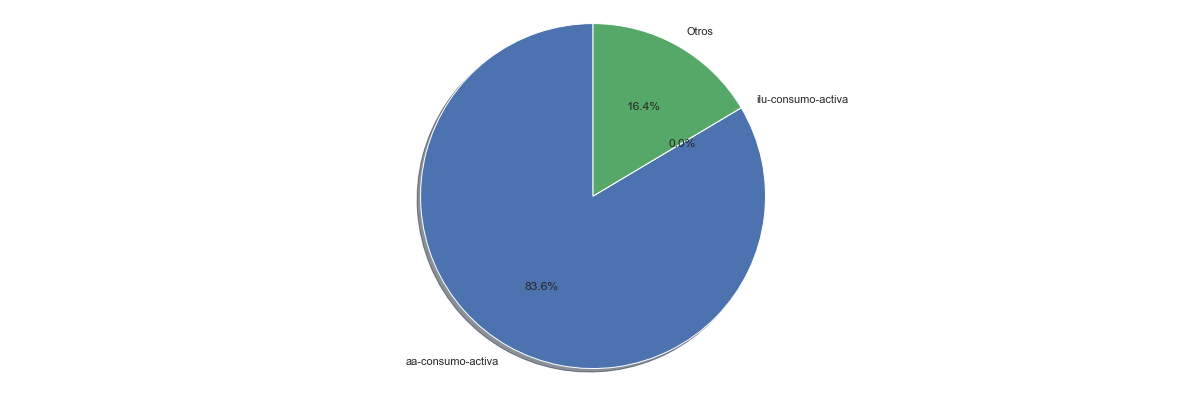

,value,variable
0,2101.09,aa-consumo-activa
1,0.00,ilu-consumo-activa
2,413.50,Otros


In [10]:
cargas_grouped = cargas_month['value'].sum()
consumo_otros =  consumo_sede -cargas_grouped 
consumo_otros

piechart_df = cargas_month[["value","variable"]]
piechart_df.loc[-1] = [consumo_otros, "Otros"]
piechart_df.reset_index(inplace=True, drop=True)
piechart_df['value'] = piechart_df['value'].round(decimals = 2)


fig1, ax1 = plt.subplots()
ax1.pie(piechart_df["value"],  labels=piechart_df["variable"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


piechart_df

Text(0.5, 1.0, 'Consumo diario de energía activa (kWh) en el último mes')

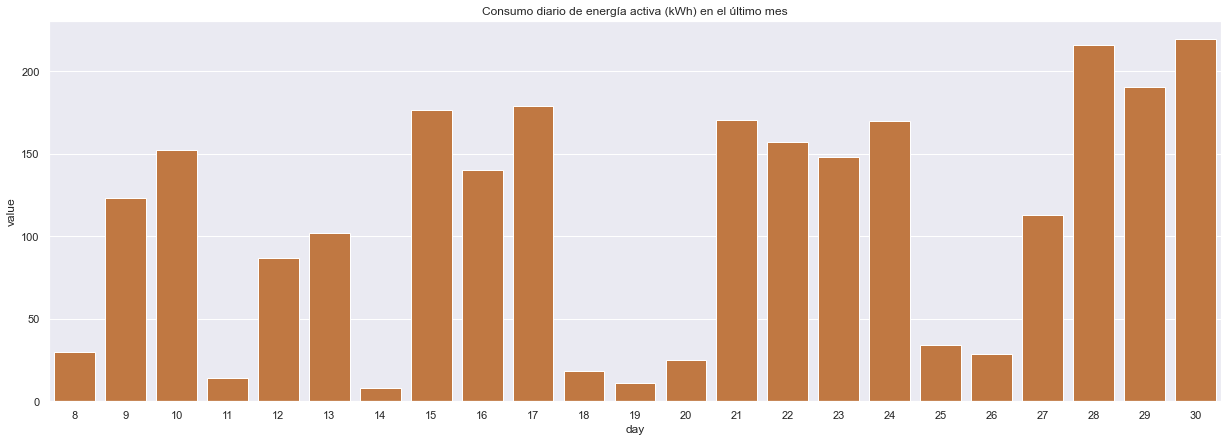

In [11]:
sns.barplot(x="day", y="value", data=front_day, color="#D5752D")
plt.title("Consumo diario de energía activa (kWh) en el último mes")

Text(0.5, 1.0, 'Consumo diario de energía activa (kWh) en el último mes')

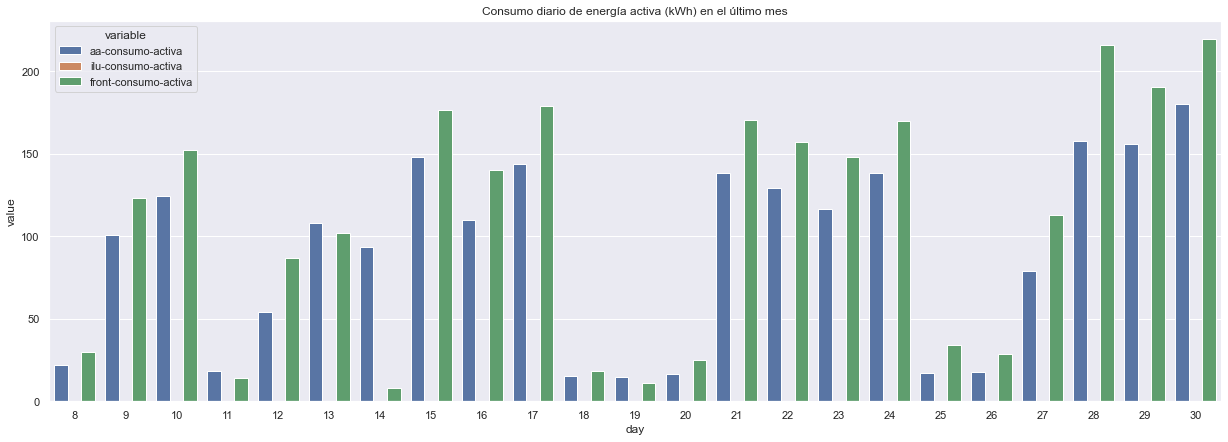

In [12]:
sns.barplot(x="day", y="value", hue="variable", data=pd.concat([cargas_day, front_day]))
plt.title("Consumo diario de energía activa (kWh) en el último mes")

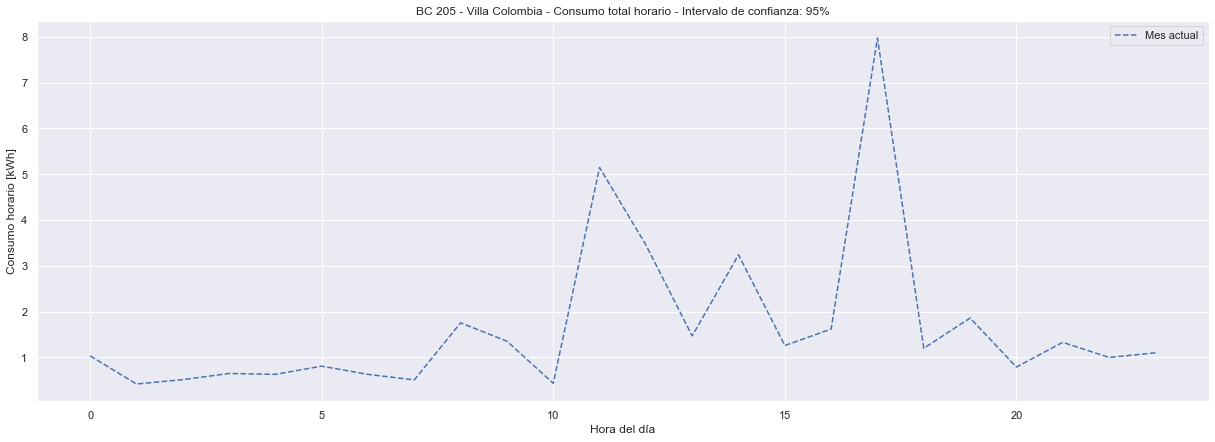

In [13]:
# df_baseline_datehour = past_hour.groupby('datetime').sum()
df_study_datehour = front_hour.groupby('datetime').sum()
# df_baseline_datehour['hour'] = df_baseline_datehour.index.hour
df_study_datehour['hour'] = df_study_datehour.index.hour

device_name = df['device_name'][0]
title = f"{device_name} - Consumo total horario"


# sns.lineplot(
#     x='hour',
#     y='value',
#     hue=None,
#     data=df_baseline_datehour.reset_index(), 
#     ci=confidence_interval,
#     estimator=np.median,
#     # palette="flare",
#     label="Consumo meses pasados"
# )
sns.lineplot(
    x='hour',
    y='value',
    hue=None,
    linestyle="dashed",
    data=df_study_datehour.reset_index(), 
    ci=None,
    legend=False,
    estimator=np.median,
    # palette="flare",
    label="Mes actual"
)
plt.title(title + f" - Intervalo de confianza: {confidence_interval}%")
plt.xlabel('Hora del día')
plt.ylabel('Consumo horario [kWh]')
plt.legend()
plt.show()

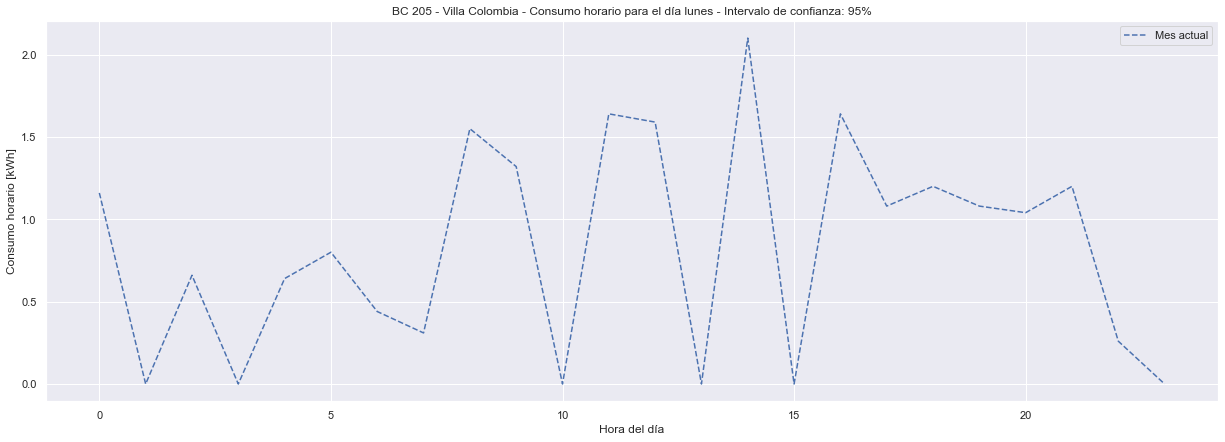

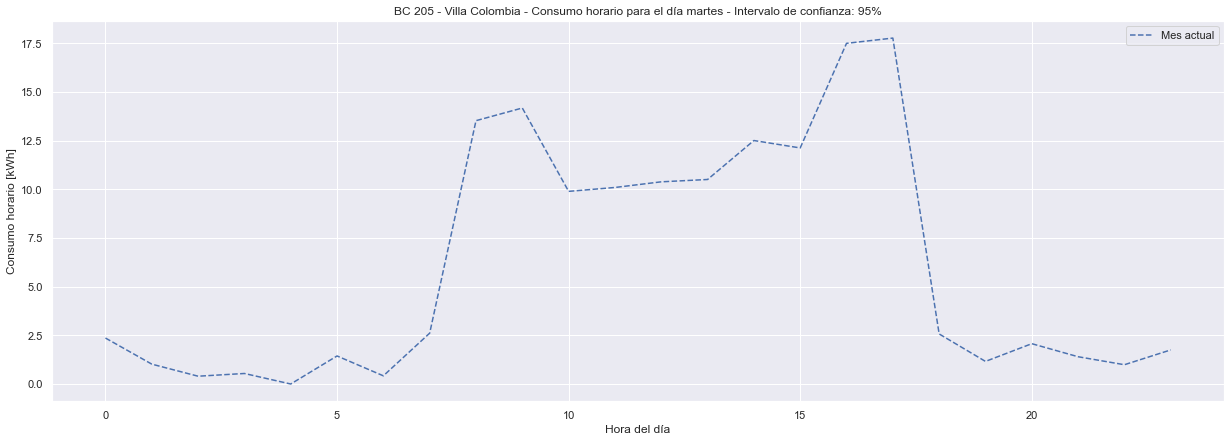

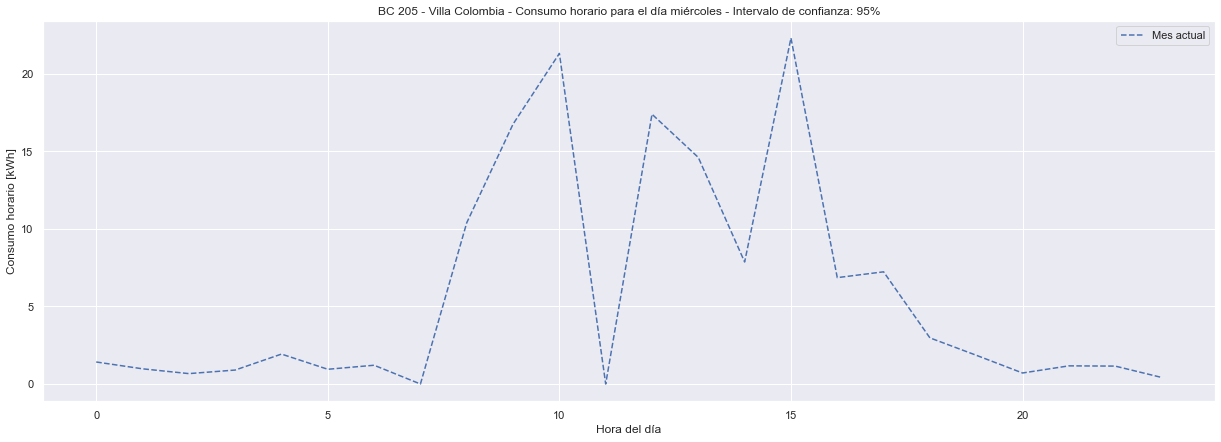

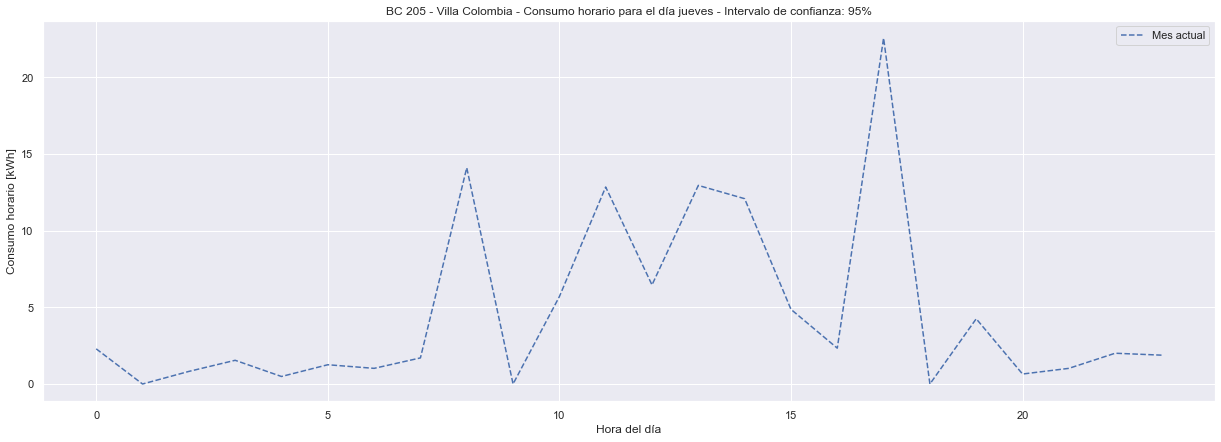

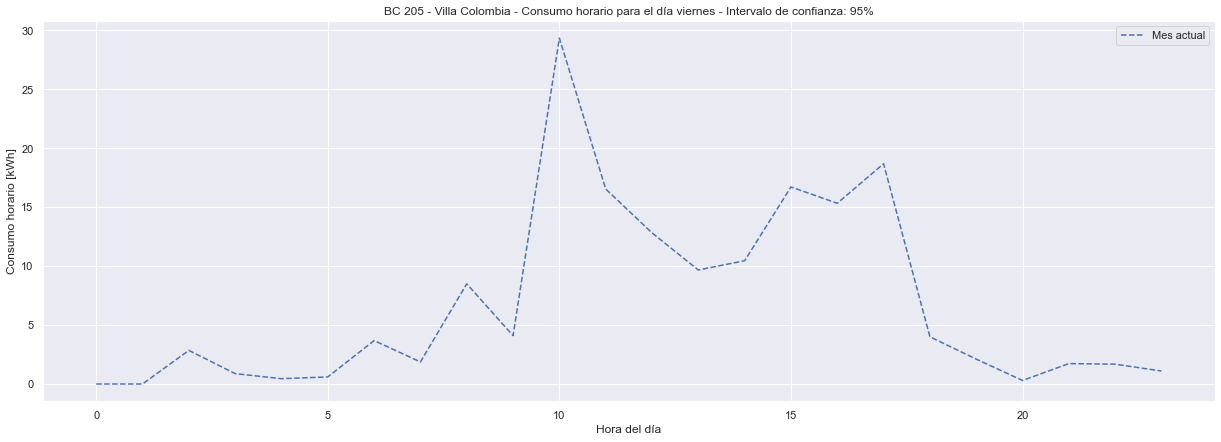

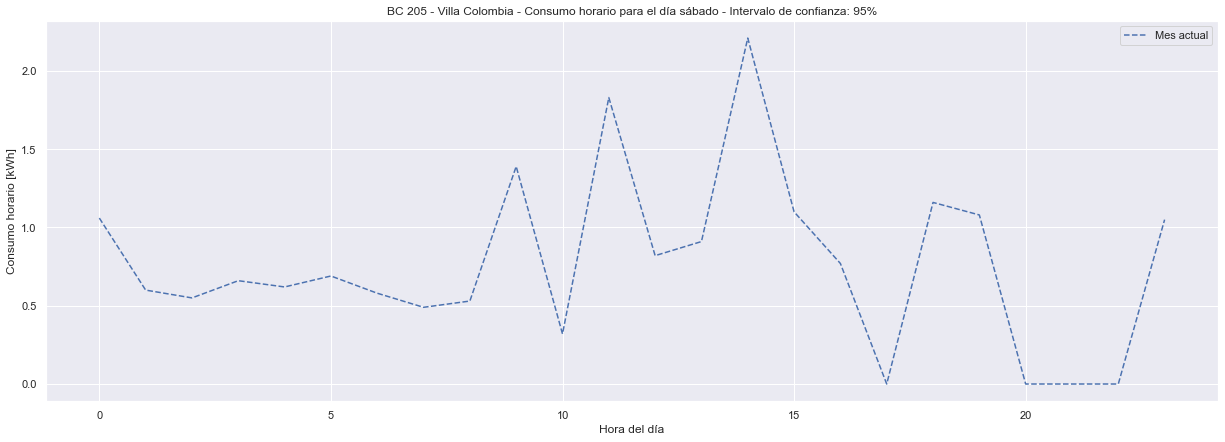

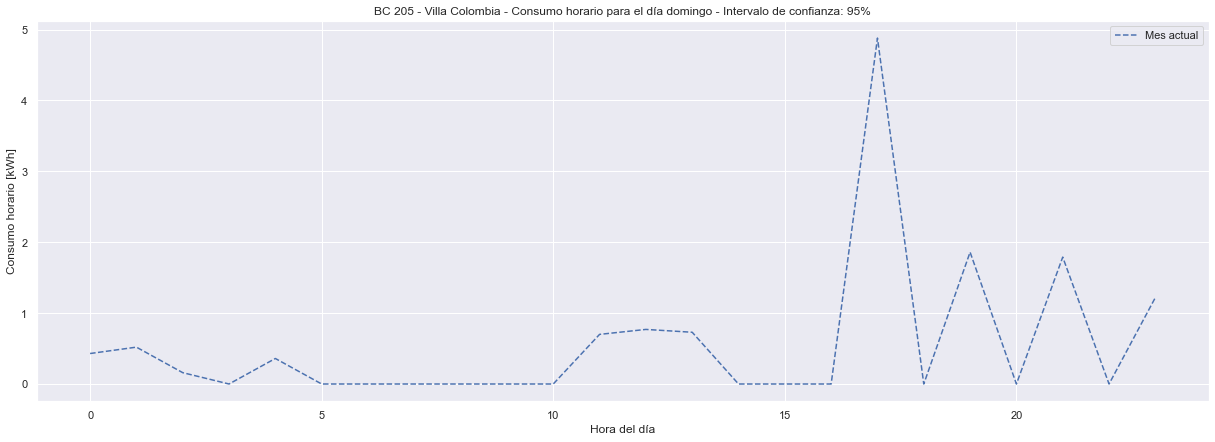

In [14]:
for day in dct_dow.values():
    # df_plot_bl = past_hour[(past_hour['dow']==day)].copy()
    df_plot_s = front_hour[(front_hour['dow']==day)].copy()
    device_name = df['device_name'][0]
    title = f"{device_name} - Consumo horario para el día {day}"
    
    
    # sns.lineplot(
    #     x='hour',
    #     y='value',
    #     hue=None,
    #     data=df_plot_bl.reset_index(), 
    #     ci=confidence_interval,
    #     estimator=np.median,
    #     # palette="flare",
    #     label="Consumo meses pasados"
    # )
    sns.lineplot(
        x='hour',
        y='value',
        hue=None,
        linestyle="dashed",
        data=df_plot_s.reset_index(), 
        ci=None,
        legend=False,
        estimator=np.median,
        # palette="flare",
        label="Mes actual"
    )
    plt.title(title + f" - Intervalo de confianza: {confidence_interval}%")
    plt.xlabel('Hora del día')
    plt.ylabel('Consumo horario [kWh]')
    plt.legend()
    plt.show()

Text(0.5, 1.0, 'Matriz de consumo horario (frontera) [kWh] en el último mes')

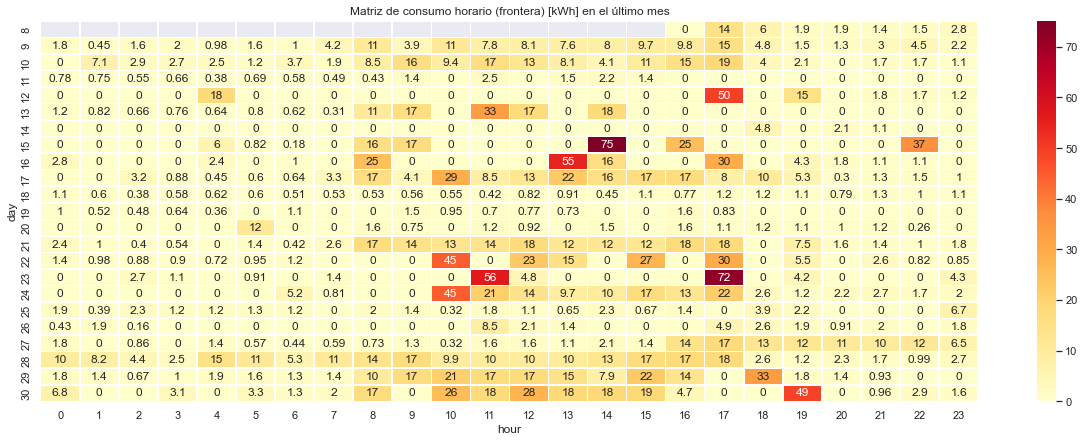

In [15]:
b = front_hour[["day","hour", "value"]]
matrix = b.pivot("day", "hour", "value")
sns.heatmap(matrix, annot=True, cmap="YlOrRd", linewidths=.5)
plt.title("Matriz de consumo horario (frontera) [kWh] en el último mes")

Text(0.5, 1.0, 'Matriz de consumo horario (Cargas) [kWh] en el último mes')

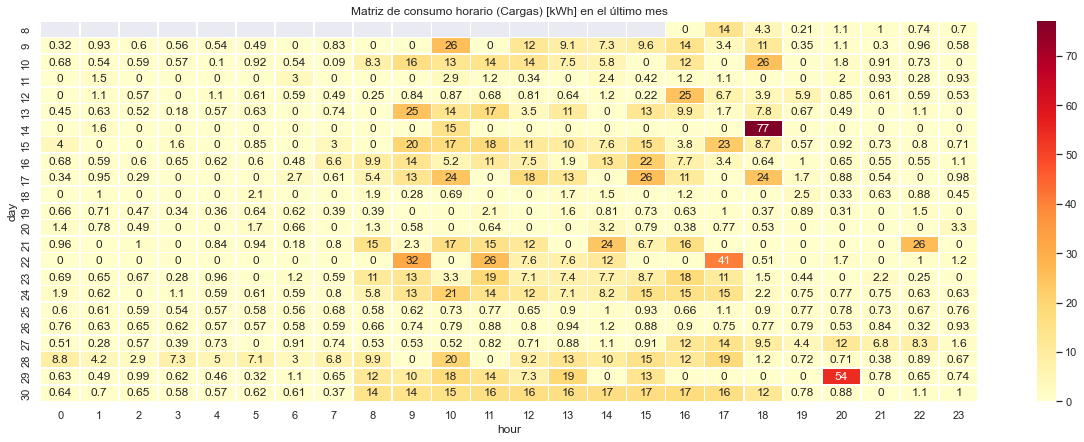

In [16]:
c = cargas_hour[["day","hour", "value"]].groupby(by=["day","hour"]).sum().reset_index()
matrix_c = c.pivot("day", "hour", "value")
sns.heatmap(matrix_c, annot=True, cmap="YlOrRd", linewidths=.5)
plt.title("Matriz de consumo horario (Cargas) [kWh] en el último mes")

Text(0.5, 1.0, 'Matriz de consumo reactiva horario (Front) [kVArh] en el último mes')

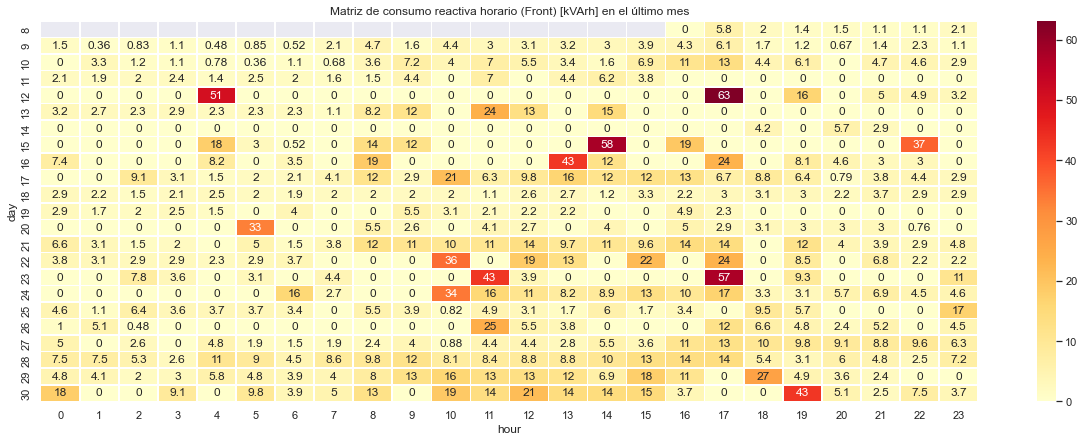

In [17]:
r = front_reactiva_hour[["day","hour", "value"]].groupby(by=["day","hour"]).sum().reset_index()
matrix_r = r.pivot("day", "hour", "value")
sns.heatmap(matrix_r, annot=True, cmap="YlOrRd", linewidths=.5)
plt.title("Matriz de consumo reactiva horario (Front) [kVArh] en el último mes")

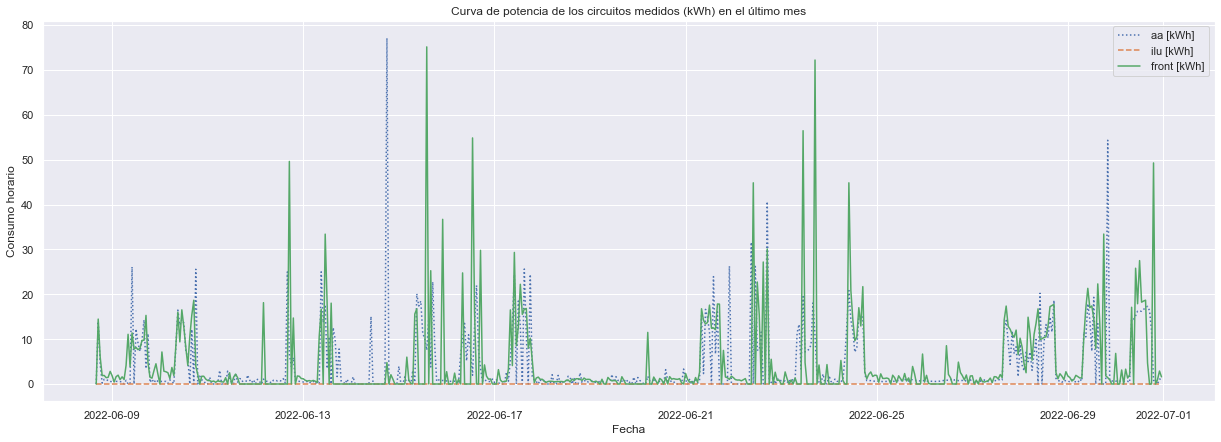

In [18]:
sns.lineplot(
        x='datetime',
        y='value',
        linestyle="dotted",
        data=cargas_hour[cargas_hour["variable"]=="aa-consumo-activa"], 
        ci=None,
        legend=False,
        # palette="flare",
        label=" aa [kWh]"
    )

sns.lineplot(
        x='datetime',
        y='value',
        linestyle="dashed",
        data=cargas_hour[cargas_hour["variable"]=="ilu-consumo-activa"], 
        ci=None,
        legend=False,
        # palette="flare",
        label=" ilu [kWh]"
    )

sns.lineplot(
        x='datetime',
        y='value',
        linestyle="solid",
        data=front_hour[front_hour["variable"]=="front-consumo-activa"], 
        ci=None,
        legend=False,
        # palette="flare",
        label=" front [kWh]"
    )



plt.title("Curva de potencia de los circuitos medidos (kWh) en el último mes")
plt.xlabel('Fecha')
plt.ylabel('Consumo horario')
plt.legend()

Durante el mes pasado se consumió un total de:  290.94 kWh fuera del horario establecido


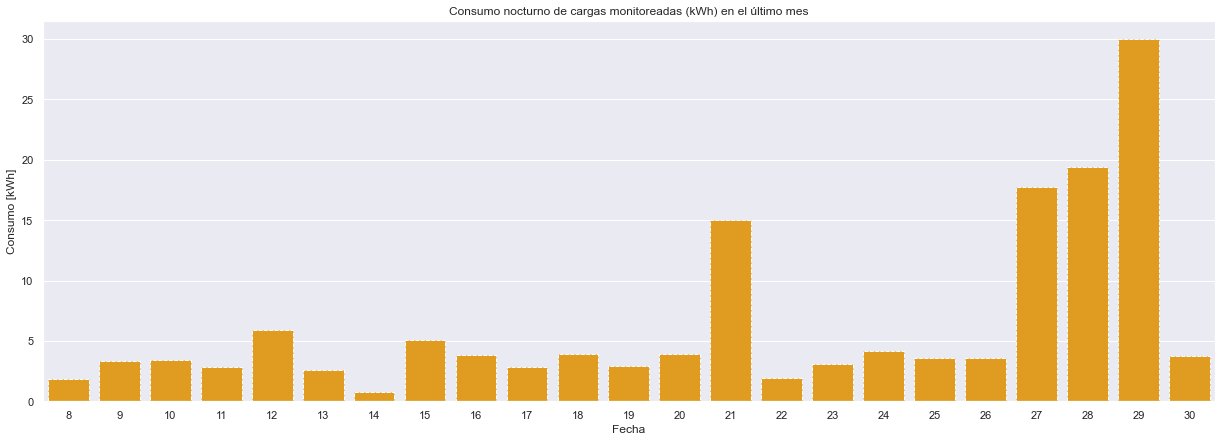

In [19]:

sns.barplot(
        x='day',
        y='value',
        hue=None,
        linestyle="dashed",
        data=Cargas_Nocturne_day, 
        ci=None,
        color="Orange",
    )
plt.title("Consumo nocturno de cargas monitoreadas (kWh) en el último mes")
plt.xlabel('Fecha')
plt.ylabel('Consumo [kWh]')


consumo_nocturno = round(Cargas_Nocturne_day["value"].sum(),2)

print("Durante el mes pasado se consumió un total de: ", consumo_nocturno, "kWh fuera del horario establecido")